In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(RColorBrewer)
library(gridExtra)
library(stats)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [4]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("../data/otu_table_wtax.biom", "../data/otusn.tree")
sample.data = import_qiime_sample_data("../data/ABCD_combined_reads_mapper.tsv")
sample.data$Density = asNumeric(sample.data$Density)
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.bulk = prune_samples((row.names(physeq.md) %in% grep("bulk", 
                                                           row.names(physeq.md), 
                                                           value=TRUE))& 
                            (physeq.md$Treatment %in% c("12CCPS", "13CCPS", "13CXPS")), physeq)
physeq.bulk = transform_sample_counts(physeq.bulk, function(x) x/sum(x))

In [5]:
%%R
bulk.mdf = psmelt(physeq.bulk)
tbl_df(bulk.mdf)

Source: local data frame [74,832 x 18]

     OTU          Sample  Abundance      X.SampleID BarcodeSequence Day Density
1  OTU.1   13C.PS.7.bulk 0.17329700   13C.PS.7.bulk      TCAGCAGTAG   7      NA
2  OTU.1   13C.PS.3.bulk 0.15170082   13C.PS.3.bulk      TCAGCAGATG   3      NA
3  OTU.1  13C.PS.30.bulk 0.11972403  13C.PS.30.bulk      TCAGCATCCA  30      NA
4  OTU.1  13C.PS.14.bulk 0.11573861  13C.PS.14.bulk      TCAGCAGTTC  14      NA
5  OTU.1  cont.PS.1.bulk 0.11308901  cont.PS.1.bulk      TCAGAGGACT   1      NA
6  OTU.1   13X.PS.7.bulk 0.10688592   13X.PS.7.bulk      TCACTGACTG   7      NA
7  OTU.1  cont.PS.3.bulk 0.10443536  cont.PS.3.bulk      TCAGCAACCT   3      NA
8  OTU.1   13X.PS.1.bulk 0.09366793   13X.PS.1.bulk      TCACTCACTC   1      NA
9  OTU.1   13X.PS.3.bulk 0.08963964   13X.PS.3.bulk      TCACTCGAGT   3      NA
10 OTU.1 cont.PS.30.bulk 0.07988981 cont.PS.30.bulk      TCACGTGATC  30      NA
..   ...             ...        ...             ...             ... ...     ...


In [6]:
%%R
RA.df = ddply(bulk.mdf, .(OTU), 
        summarize, 
        mean.abund = mean(Abundance), 
        max.abund = max(Abundance),
        min.abund = min(Abundance))

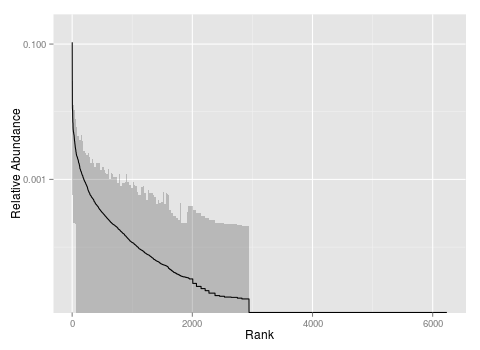

In [7]:
%%R -h 350
RA.df.sorted = RA.df[order(-RA.df$mean.abund, -RA.df$max.abund),]
RA.df.sorted$Rank = 1:nrow(RA.df.sorted)

p = ggplot(RA.df.sorted, aes(y = mean.abund, x = Rank))
p = p + geom_ribbon(aes(ymax = max.abund, ymin = min.abund), alpha = 0.25)
p = p + geom_line()
p = p + scale_y_log10()
p = p + labs(y = "Relative Abundance")

p

In [8]:
%%R
df.l2fc = read.table("../data/l2fc_table.csv", 
                    header = TRUE,
                    sep = ",")

In [9]:
%%R
mdf.byday = ddply(bulk.mdf, .(Day, OTU), summarize, mean_day_abundance = mean(Abundance))
mdf.byday = mdf.byday[order(mdf.byday$Day, -mdf.byday$mean_day_abundance),]
mdf.1 = subset(mdf.byday, Day == 1)
mdf.1$Rank = rank(-mdf.1$mean_day_abundance, ties.method = "random")
mdf.byday.ranked = join(mdf.byday, mdf.1[,c("OTU","Rank")], by = "OTU")

In [10]:
%%R
FDR = 0.10

df.l2fc.rspndr = df.l2fc %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>% 
    filter(minP <= FDR)

In [11]:
%%R
FDR = 0.10

d.cell = left_join(df.l2fc.rspndr %>% filter(Treatment == "13CCPS"), mdf.byday.ranked)
d.xyl = left_join(df.l2fc.rspndr %>% filter(Treatment == "13CXPS"), mdf.byday.ranked)

Joining by: "OTU"
Joining by: "OTU"


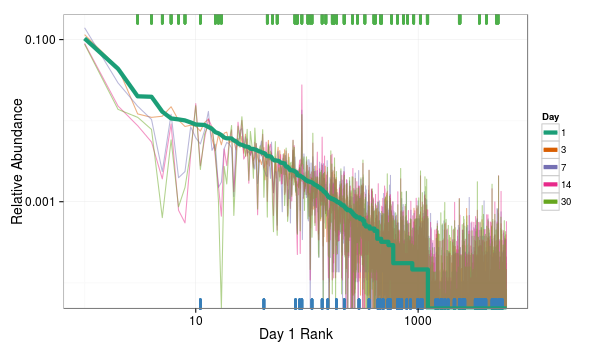

In [36]:
%%R -w 600 -h 350
getPalette = colorRampPalette(brewer.pal(5, "Dark2"))

p = ggplot(mdf.byday.ranked, aes(x = Rank, y = mean_day_abundance, color = factor(Day))) 

#p = p + geom_vline(data = d.cell, aes(xintercept = Rank), color = "#377eb8", alpha = 0.25, size = 1)
#p = p + geom_vline(data = d.xyl, aes(xintercept = Rank), color = "#4daf4a", alpha = 0.25, size = 1)

p = p + geom_line(alpha = 0.5) 

p = p + geom_rug(data = d.cell, color = "#377eb8", sides = "b", size = 1.25)
p = p + geom_rug(data = d.xyl, color = "#4daf4a", sides = "t", size = 1.25)

p = p + geom_line(data = subset(mdf.byday.ranked, Day == 1), size = 2)

p = p + scale_y_log10()

p = p + scale_x_log10()

p = p + scale_color_manual(values=getPalette(5))

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 12), 
              axis.title = element_text(size = 14))

p = p + labs(x = "Day 1 Rank", y = "Relative Abundance", color = "Day")

p.rabund = p

p.rabund

In [13]:
%%R -h 400 -w 700

colours = c("#377eb8", "#4daf4a")
getPalette = colorRampPalette(brewer.pal(9, "Set1"))

FDR = 0.10

tax = data.frame(tax_table(physeq.bulk))
tax$OTU = rownames(tax)

OTUs.wP = unique(df.l2fc$OTU)

RA.df.wP = subset(RA.df, OTU %in% OTUs.wP)

RA.df.wP.sorted = RA.df.wP[order(-RA.df.wP$mean.abund, -RA.df.wP$max.abund),]
RA.df.wP.sorted$Rank = 1:nrow(RA.df.wP.sorted)

df.l2fc.p.summarize = ddply(df.l2fc, .(OTU, Treatment), summarize, p.adj.min = min(padj))
df.l2fc.p.summarize = left_join(df_all.p.summarize, RA.df.wP.sorted)
df.l2fc.p.summarize = left_join(df_all.p.summarize, tax)

#d = RA.df.wP.sorted
d = df.l2fc.p.summarize
ds = subset(d, (p.adj.min <= FDR))
p = as.character(levels(factor(ds$Rank2)))
quote(paste("italic(", p, ")", sep=""))

t = parse(text = paste("italic(", p, ")", sep=""))

p = ggplot(d, aes(y = mean.abund, x = Rank))
p = p + geom_ribbon(aes(ymax = max.abund, ymin = min.abund), alpha = 0.25)

p = p + geom_rug(data = subset(d, (p.adj.min <= FDR)&(Treatment=="13CXPS")), 
                 sides = "t", aes(color = Rank2), size = 1.5, alpha = 0.5)
p = p + geom_rug(data = subset(d, (p.adj.min <= FDR)&(Treatment=="13CCPS")), 
                 sides = "b", aes(color = Rank2), size = 1.5, alpha = 0.5)

p = p + geom_line(size = 1)

p = p + scale_color_manual(values=getPalette(9), labels = t)

p = p + scale_y_log10()

p = p + labs(y = "Relative Abundance", color = "Phylum")

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 12), 
              axis.title = element_text(size = 14))

p = p + guides(fill = guide_legend(label.hjust = 0))

p.rabund2 = p

p

Error in left_join(df_all.p.summarize, RA.df.wP.sorted) : 
  object 'df_all.p.summarize' not found
In addition: Warning messages:
1: joining character vector and factor, coercing into character vector 
2: joining character vector and factor, coercing into character vector
Error in left_join(df_all.p.summarize, RA.df.wP.sorted) : 
  object 'df_all.p.summarize' not found


In [14]:
%%R
cellulose.mean_abund = subset(df.l2fc.p.summarize, (p.adj.min <= FDR)&(Treatment=="13CCPS"))$mean.abund
xylose.mean_abund = subset(df.l2fc.p.summarize, (p.adj.min <= FDR)&(Treatment=="13CXPS"))$mean.abund

wilcox.test(xylose.mean_abund, cellulose.mean_abund, alternative = "greater")

Error in wilcox.test.default(xylose.mean_abund, cellulose.mean_abund,  : 
  'x' must be numeric


In [15]:
%%R
df.shifts = read.csv("../data/density_shifts.csv", sep = ",", header = TRUE, )
df.shifts$shift = as.numeric(as.character(df.shifts$shift))
head(df.shifts)

       OTU        shift Day Treatment
1  OTU.759           NA   1    13CXPS
2  OTU.758  0.017597635   1    13CXPS
3  OTU.757 -0.005009263   1    13CXPS
4  OTU.756  0.009056019   1    13CXPS
5 OTU.5419 -0.003075774   1    13CXPS
6  OTU.839  0.002702782   1    13CXPS


Joining by: c("Day", "Treatment", "OTU")


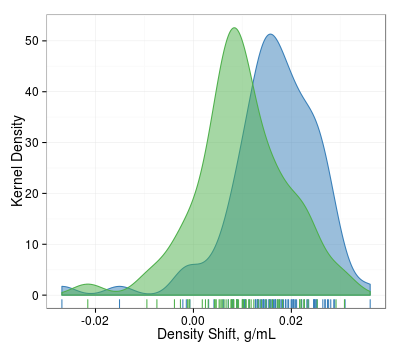

In [16]:
%%R -w 400 -h 350
df.l2fc.wShifts = left_join(df.l2fc, df.shifts)

df.plot = subset(df.l2fc.wShifts, padj <= FDR)

colours = c("#377eb8", "#4daf4a")

p = ggplot(df.plot, aes(x = as.numeric(as.character(shift))))

p = p + geom_density(aes(color = Treatment, fill = Treatment), alpha = 0.50)
p = p + geom_rug(aes(color = Treatment))
p = p + scale_color_manual(values=colours) 
p = p + scale_fill_manual(values=colours)
p = p + labs(y = "Kernel Density", x = "Density Shift, g/mL")

p = p + guides(color = FALSE, fill = FALSE)

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 12), 
              axis.title = element_text(size = 14))

p.shift = p 

p

In [17]:
%%R
FDR = 0.10

df.l2fc.wShifts %>%
    filter(padj <= FDR) %>%
    group_by(Treatment) %>%
    summarize(mean.shift = mean(shift, na.rm = TRUE),
              sd.shift = sd(shift, na.rm = TRUE))

Source: local data frame [2 x 3]

  Treatment mean.shift    sd.shift
1    13CCPS 0.01630352 0.009420693
2    13CXPS 0.00976086 0.009418917


In [18]:
%%R
cellulose.shifts = subset(df.l2fc.wShifts, (Treatment == "13CCPS")&(padj <= FDR))$shift
xylose.shifts = subset(df.l2fc.wShifts, (Treatment == "13CXPS")&(padj <= FDR))$shift

wilcox.test(cellulose.shifts, xylose.shifts, alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  cellulose.shifts and xylose.shifts
W = 3687, p-value = 1.86e-06
alternative hypothesis: true location shift is greater than 0



NULL


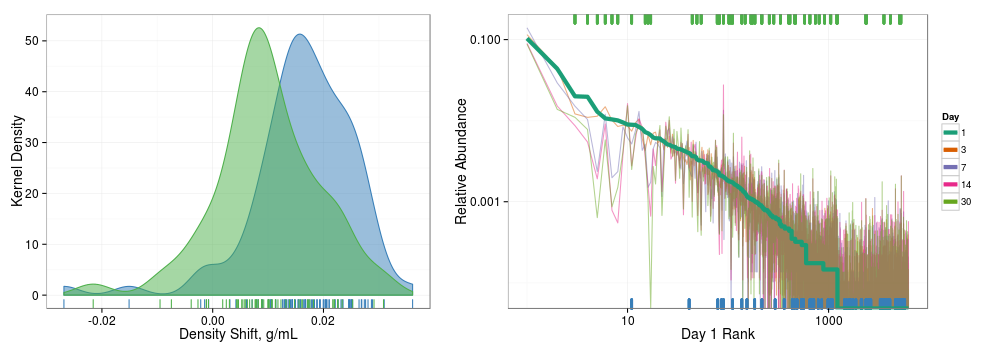

In [37]:
%%R -w 1000 -h 350

p.combined = grid.arrange(p.shift, p.rabund, widths = c(2, 2.5), ncol = 2)

p.combined

In [20]:
%%R
svg("figs/shift_and_rabund.svg", w = 10, h = 4)
grid.arrange(p.shift, p.rabund, widths = c(2, 3.75), ncol = 2)
dev.off()

png 
  2 


In [21]:
FileLink("figs/shift_and_rabund.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/shift_and_rabund.pdf

In [22]:
FileLink("figs/shift_and_rabund.svg")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/shift_and_rabund.svg

In [23]:
%%R
d = bulk.mdf %>%
    group_by(OTU, Day) %>%
    summarize(A = mean(Abundance)) %>%
    group_by(Day) %>%
    mutate(Rank = base::rank(desc(A), ties.method = "random"))

d = left_join(d, df.l2fc)

Joining by: c("OTU", "Day")


In [24]:
%%R
FDR = 0.10

d %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2, Rank5) %>%
    summarize(N = n(), R.mean = mean(Rank)) %>%
    group_by(Treatment) %>%
    filter(rank(R.mean, ties.method="first")<=5) %>%
    arrange(R.mean)

Source: local data frame [10 x 6]
Groups: Treatment

        OTU Treatment          Rank2             Rank5 N   R.mean
1     OTU.5    13CCPS Proteobacteria    Comamonadaceae 1 13.00000
2     OTU.6    13CCPS Proteobacteria  Pseudomonadaceae 3 18.33333
3   OTU.114    13CCPS Proteobacteria  Oxalobacteraceae 1 49.00000
4    OTU.19    13CCPS Proteobacteria      Rhizobiaceae 1 59.00000
5    OTU.28    13CCPS Proteobacteria      Rhizobiaceae 1 64.00000
6  OTU.4743    13CXPS     Firmicutes    Planococcaceae 1  3.00000
7     OTU.8    13CXPS     Firmicutes    Planococcaceae 1  4.00000
8   OTU.159    13CXPS  Bacteroidetes Flavobacteriaceae 1  5.00000
9     OTU.4    13CXPS Actinobacteria         Agromyces 2  7.00000
10 OTU.6203    13CXPS  Bacteroidetes Flavobacteriaceae 1  8.00000


In [25]:
%%R
FDR = 0.10

d %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2, Rank5) %>%
    summarize(N = n(), R.mean = mean(Rank)) %>%
    group_by() %>%
    filter(rank(R.mean, ties.method="first")<=10) %>%
    arrange(R.mean)

Source: local data frame [10 x 6]

        OTU Treatment          Rank2                Rank5 N   R.mean
1  OTU.4743    13CXPS     Firmicutes       Planococcaceae 1  3.00000
2     OTU.8    13CXPS     Firmicutes       Planococcaceae 1  4.00000
3   OTU.159    13CXPS  Bacteroidetes    Flavobacteriaceae 1  5.00000
4     OTU.4    13CXPS Actinobacteria            Agromyces 2  7.00000
5  OTU.6203    13CXPS  Bacteroidetes    Flavobacteriaceae 1  8.00000
6    OTU.14    13CXPS  Bacteroidetes    Flavobacteriaceae 2 10.00000
7     OTU.5    13CCPS Proteobacteria       Comamonadaceae 1 13.00000
8     OTU.9    13CXPS     Firmicutes          Bacillaceae 1 15.00000
9    OTU.48    13CXPS Proteobacteria uncultured_bacterium 2 16.50000
10    OTU.6    13CCPS Proteobacteria     Pseudomonadaceae 3 18.33333


In [26]:
%%R
FDR = 0.10

d1 = bulk.mdf %>%
    group_by(OTU) %>%
    summarize(A = mean(Abundance))

d2 = df.l2fc %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR)

left_join(d2, d1) %>% group_by() %>% filter(Treatment == "13CXPS") %>% filter(rank(A, ties.method="first")<=3)

Joining by: "OTU"
Source: local data frame [3 x 4]

       OTU Treatment        minP            A
1 OTU.1040    13CXPS 0.002183426 3.567176e-05
2 OTU.1069    13CXPS 0.024397775 1.760687e-05
3   OTU.68    13CXPS 0.035145142 3.753754e-05


In [27]:
%%R
FDR = 0.10

d1 = bulk.mdf %>%
    group_by(OTU, Rank2) %>%
    summarize(N = sum(Abundance == 0) / length(Abundance))

d2 = df.l2fc %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR)

left_join(d2, d1) %>% group_by() %>% arrange(desc(N))

Joining by: "OTU"
Source: local data frame [112 x 5]

        OTU Treatment        minP           Rank2         N
1  OTU.1312    13CCPS 0.038756607  Proteobacteria 1.0000000
2   OTU.862    13CCPS 0.003516253  Actinobacteria 1.0000000
3  OTU.1023    13CCPS 0.002977674 Verrucomicrobia 0.9166667
4  OTU.1065    13CCPS 0.001760123  Planctomycetes 0.9166667
5  OTU.1069    13CXPS 0.024397775      Firmicutes 0.9166667
6  OTU.3594    13CCPS 0.078311842  Proteobacteria 0.9166667
7  OTU.5539    13CCPS 0.009566368  Proteobacteria 0.9166667
8  OTU.6062    13CCPS 0.017721373  Proteobacteria 0.9166667
9    OTU.68    13CXPS 0.035145142  Proteobacteria 0.9166667
10  OTU.971    13CCPS 0.058152294     Chloroflexi 0.9166667
..      ...       ...         ...             ...       ...


In [28]:
%%R
copy.df = read.csv("../data/eco_metrics.csv")
head(copy.df)

  Day Treatment    OTU log2FoldChange     lfcSE    Rank1          Rank2
1   3    13CCPS OTU.32       2.338347 0.3699722 Bacteria Proteobacteria
2   3    13CXPS OTU.32       3.001541 0.4185308 Bacteria Proteobacteria
3   7    13CXPS OTU.32       2.117157 0.3736755 Bacteria Proteobacteria
4  14    13CXPS OTU.32       1.957860 0.2324777 Bacteria Proteobacteria
5   3    13CCPS  OTU.6       3.420828 0.5716729 Bacteria Proteobacteria
6   3    13CXPS  OTU.6       3.235954 0.4331299 Bacteria Proteobacteria
                Rank3           Rank4            Rank5           Rank6
1 Deltaproteobacteria    Myxococcales     Sorangiineae Sandaracinaceae
2 Deltaproteobacteria    Myxococcales     Sorangiineae Sandaracinaceae
3 Deltaproteobacteria    Myxococcales     Sorangiineae Sandaracinaceae
4 Deltaproteobacteria    Myxococcales     Sorangiineae Sandaracinaceae
5 Gammaproteobacteria Pseudomonadales Pseudomonadaceae      Cellvibrio
6 Gammaproteobacteria Pseudomonadales Pseudomonadaceae      Cellvibrio

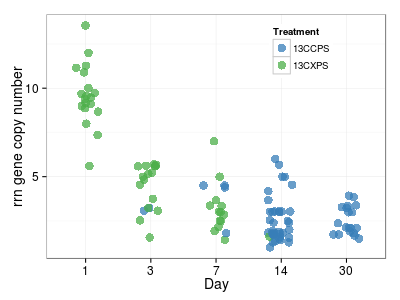

In [29]:
%%R -w 400 -h 300
FDR = 0.10
colours = c("#377eb8", "#4daf4a")

d = copy.df %>%
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment) %>%
    slice(which.min(Day)) %>%
    select(OTU, Day, Treatment, copynumber)

p = ggplot(d, aes(x = factor(Day), y = copynumber, color = Treatment))

p = p + geom_point(size = 4, alpha = 0.75, position = position_jitter(w = 0.20))

p = p + scale_color_manual(values = colours)

p = p + labs(x = "Day", y = "rrn gene copy number")

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 12), 
              axis.title = element_text(size = 14),
              legend.position = c(0.75, 0.85))

p.copy = p

p

NULL


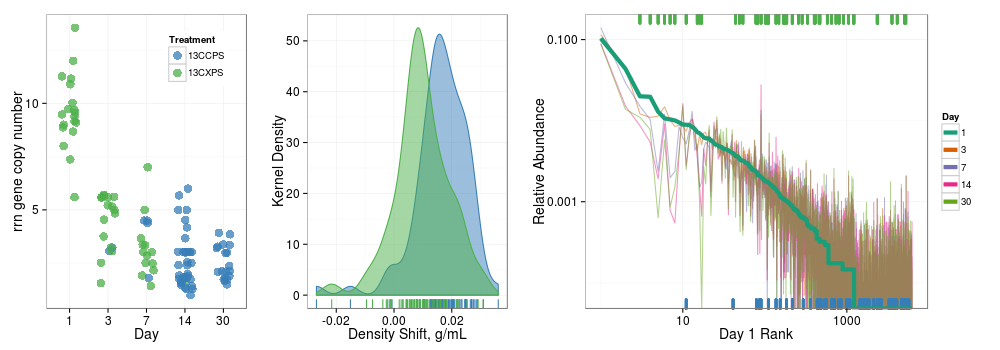

In [38]:
%%R -w 1000 -h 350
p.combined = grid.arrange(p.copy, p.shift, p.rabund, widths = c(1.5, 1.5, 2.75), ncol = 3)
p.combined

In [39]:
%%R
pdf("figs/shift_and_rabund.pdf", w = 10, h = 4)
grid.arrange(p.copy, p.shift, p.rabund, widths = c(1.5, 1.5, 2.75), ncol = 3)
dev.off()

png 
  2 


In [40]:
%%R
svg("figs/shift_and_rabund.svg", w = 12, h = 4)
grid.arrange(p.copy, p.shift, p.rabund, widths = c(1.5, 1.5, 2.75), ncol = 3)
dev.off()

png 
  2 


In [41]:
FileLink("figs/shift_and_rabund.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/shift_and_rabund.pdf

In [42]:
FileLink("figs/shift_and_rabund.svg")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/shift_and_rabund.svg